# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики


from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [46]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

Снова посмотрим на графики временных рядов

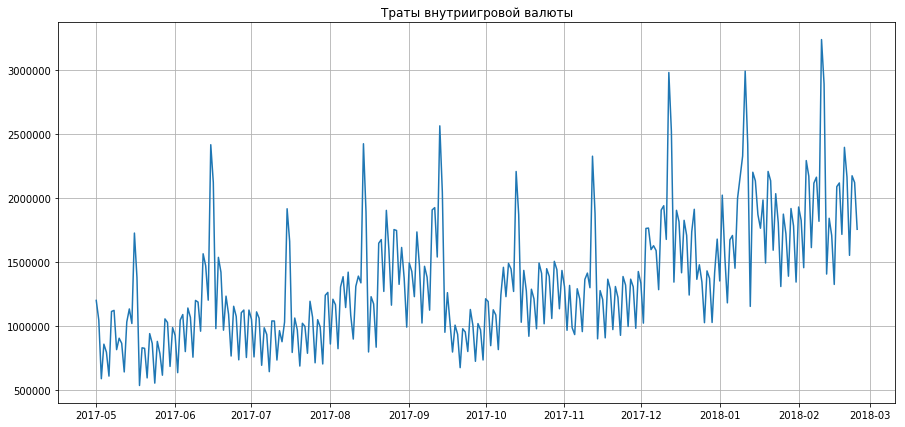

In [47]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

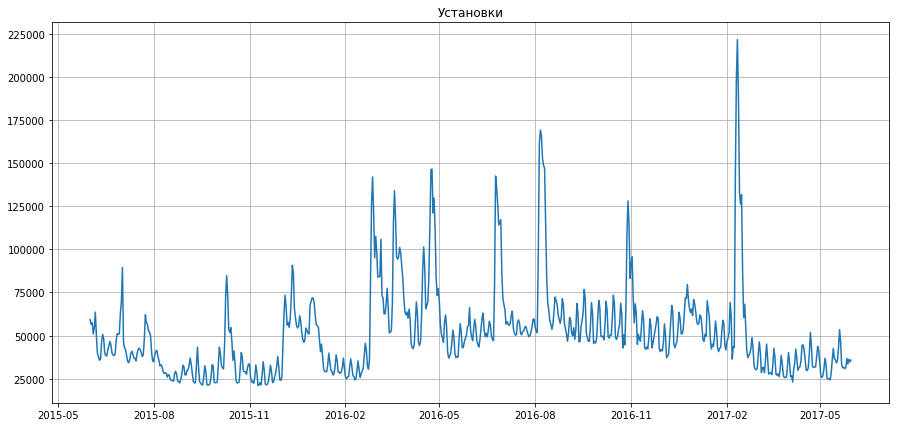

In [48]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [3]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24): #loss_function=mean_squared_error
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [22]:
data = installs.Users[0:-50]
#data

In [23]:
%%time
data = installs.Users[0:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров альфа, бета, гамма
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры (используя mean_squared_error в качестве функции потерь)
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.14958909808889503 0.02648771746164602 0.1278615041821196
Wall time: 17.8 s


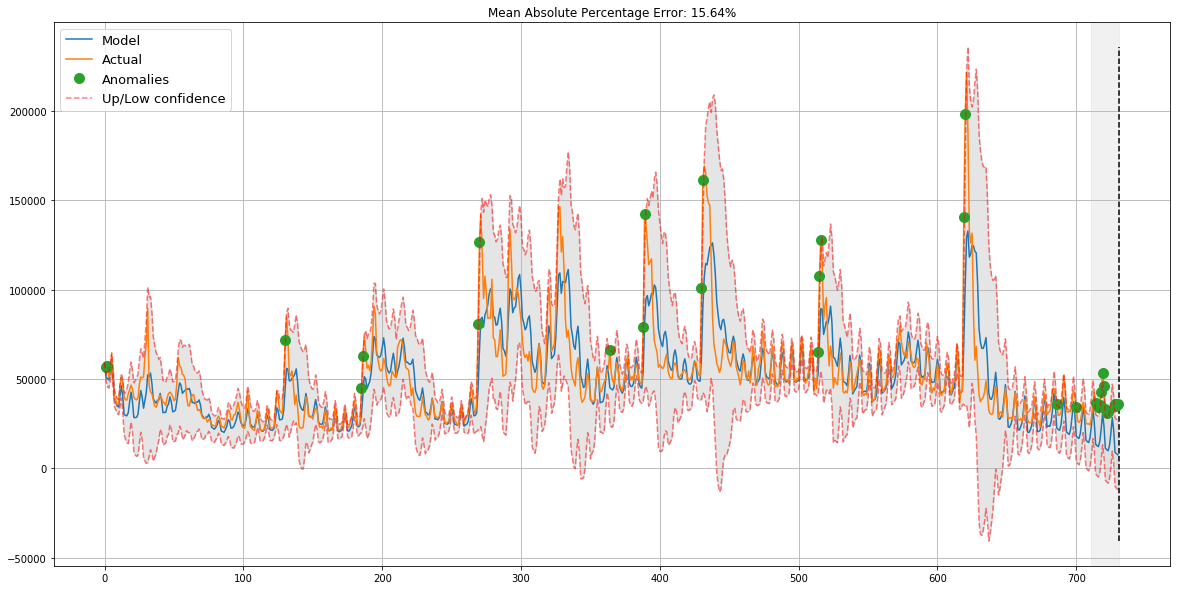

In [24]:
plotHoltWinters(installs.Users, plot_intervals=True, plot_anomalies=True)

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [32]:
%%time
data = installs.Users[500:-50] 
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.2618820126194623 0.022218824066198406 0.020541629867251943
Wall time: 5.08 s


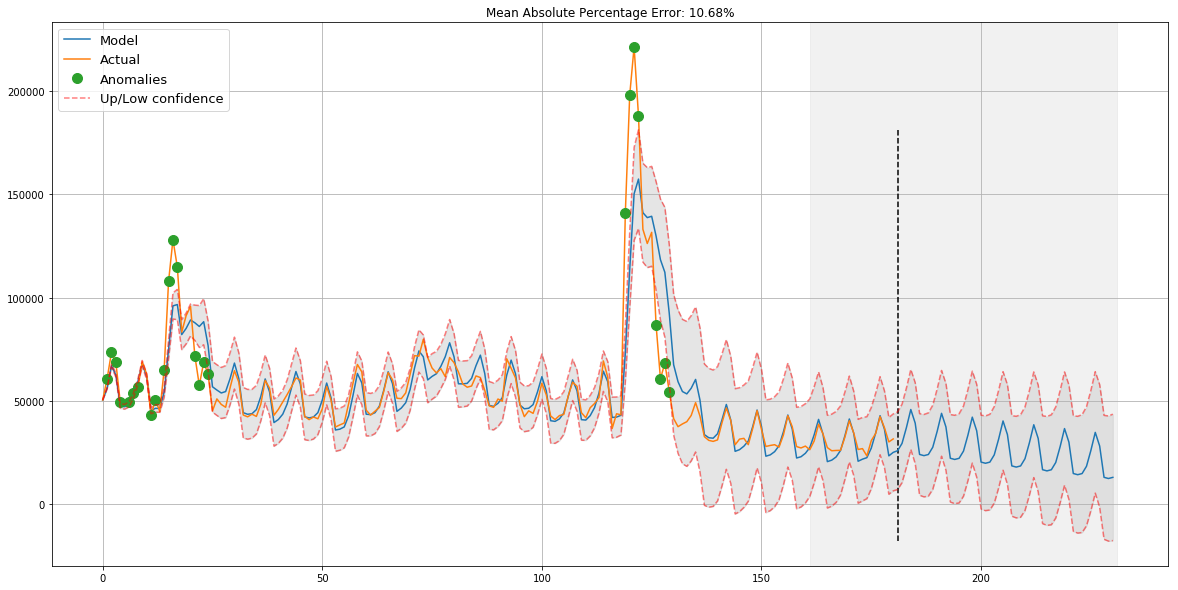

In [33]:
plotHoltWinters(installs.Users[500:-50], plot_intervals=True, plot_anomalies=True)

Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

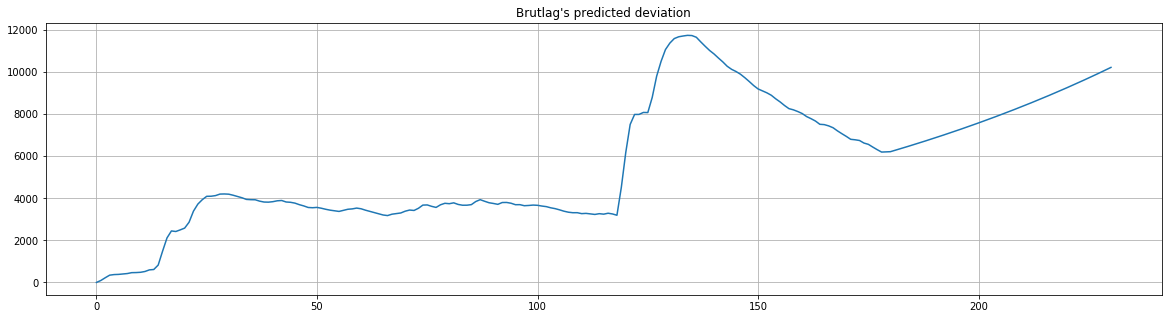

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

# Эконометрический подход

In [35]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [45]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [46]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


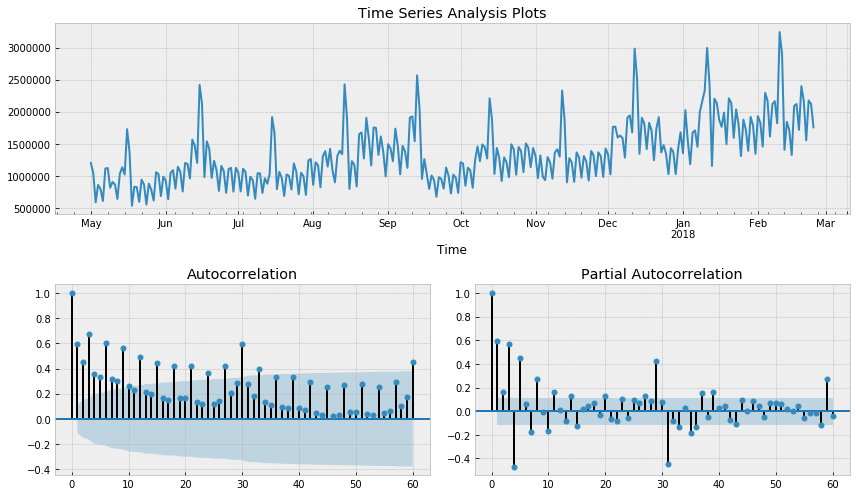

In [38]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

Критерий Дики-Фуллера: p=0.000655


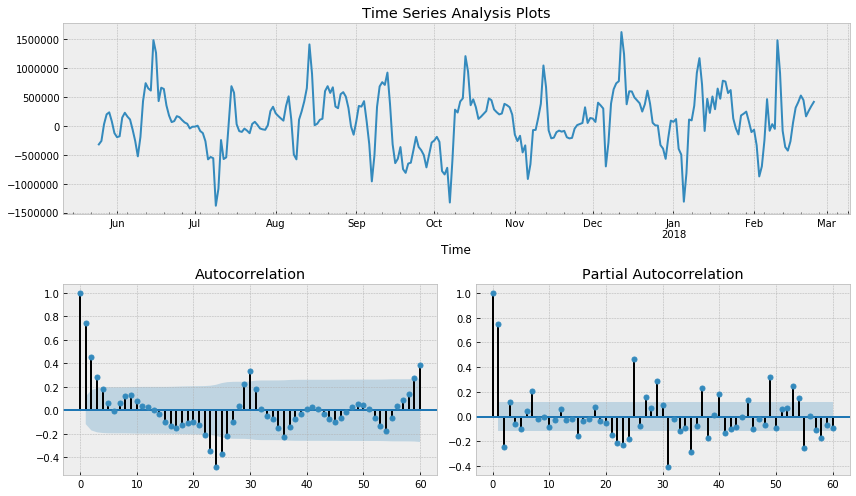

In [40]:
currency_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(24)
tsplot(currency_diff[24:], lags=60)

Критерий Дики-Фуллера: p=0.000000


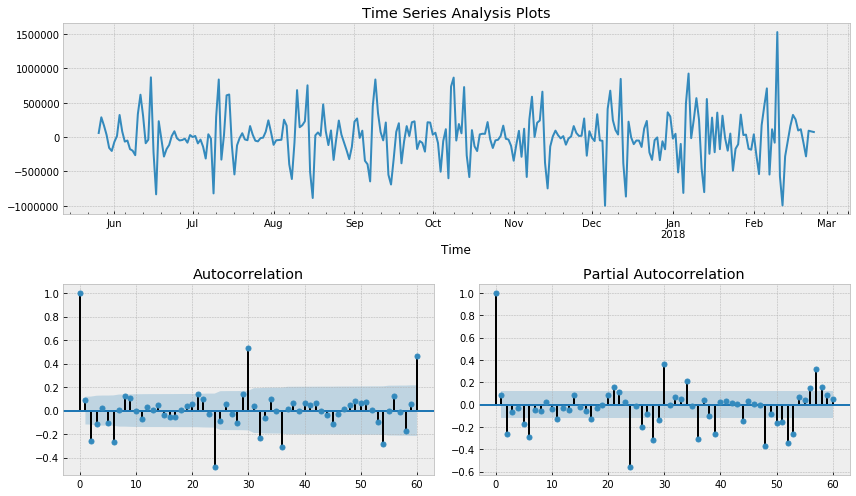

In [41]:
currency_diff = currency_diff - currency_diff.shift(1)
tsplot(currency_diff[24+1:], lags=60)

In [42]:
# p = 6 - partial autocorrelation (значимые значения, исключая сезонные)
# d = 1 - сколько раз дифференцировали
# q = 6 - autocorrelation

# P = 2 - partial autocorrelation (сколько раз значима сезонная составляющая, в нашем случае 24, 48)
# D = 1 - сезонное дифференцирование было одно
# Q = 1 - autocorrelation (сколько раз значима сезонная составляющая, в нашем случае 24, 48)
# s = 24 - значение сезонной составляющей (длина сезонности)
# зададим ограничения на возможные значения параметров для перебора
ps = range(1, 7)
d=1
qs = range(1, 7)

Ps = range(0, 3)
D= 1
Qs = range(0, 2)
s = 24

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

216

In [47]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 57min


In [48]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(5, 1, 6)x(0, 1, 1, 24)   Log Likelihood               -3811.451
Date:                            Sun, 14 Oct 2018   AIC                           7648.901
Time:                                    22:56:11   BIC                           7695.919
Sample:                                05-01-2017   HQIC                          7667.771
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0468      0.872      0.054      0.957      -1.663       1.756
ar.L2         -0.5474      0.655   

# Machine Learning для временных рядов

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [72]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [73]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [70]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [9]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

In [83]:
# Изменить функцию prepareData так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить 
# извлечение признака "день месяца" и "среднее по дню месяца"

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = pd.to_datetime(data.index)
    data["day"] = data.index.day
        
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['day_average'] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))
        
        # выкидываем закодированные средними признаки 
        data.drop(["day"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

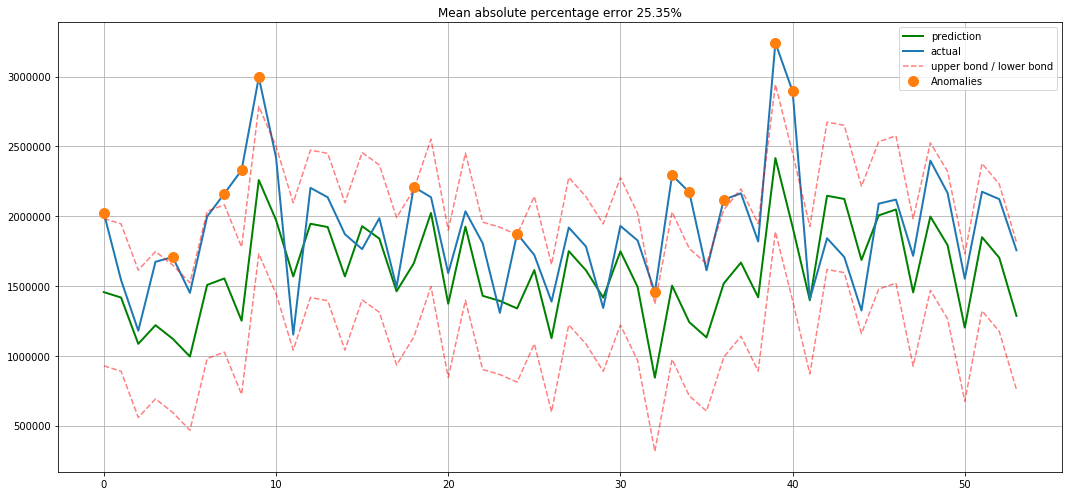

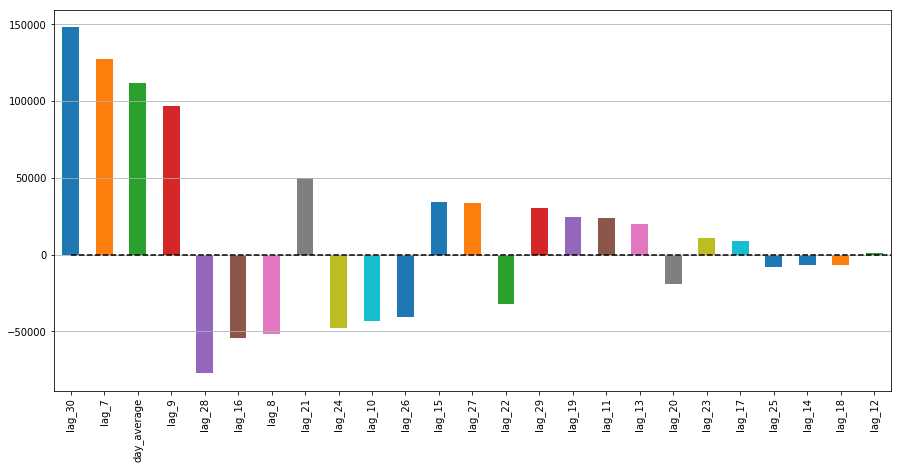

In [84]:
# Подготовить данные для построения модели, взяв lag_start = 7, чтобы модель могла прогнозировать на неделю вперед, 
# а lag_end = 31, чтобы месячная сезонность также попала в наблюдаемые моделью значения
# Построить линейную модель с target_encoding (среднее по дню месяца)

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.2, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

(216, 25)

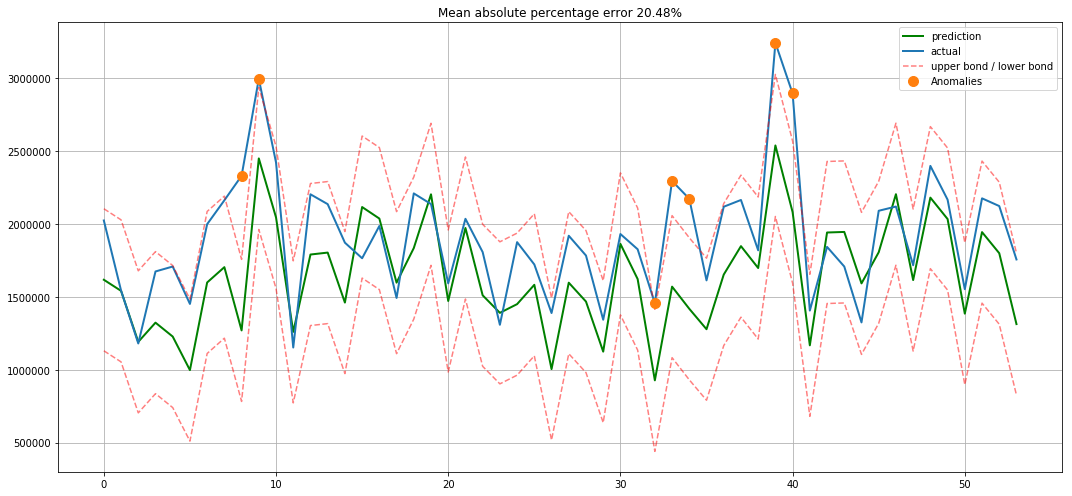

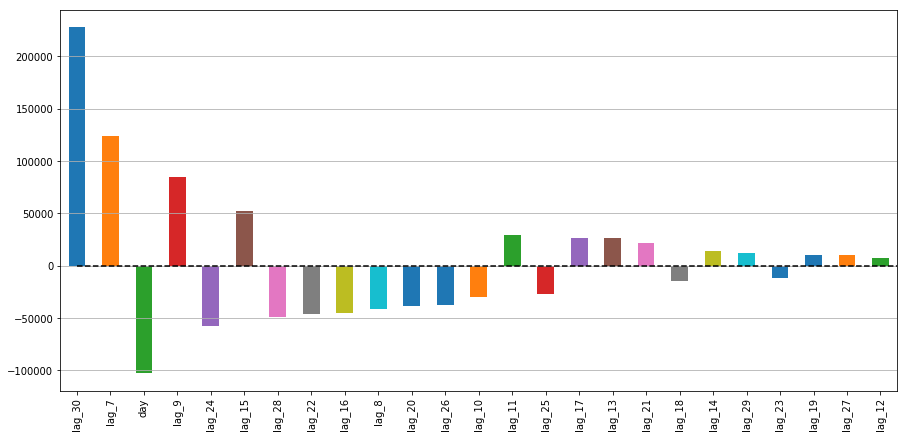

In [101]:
# Построить линейную модель без target_encoding (среднее по дню месяца) и проверить, что лучше

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.2, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

X_train.shape

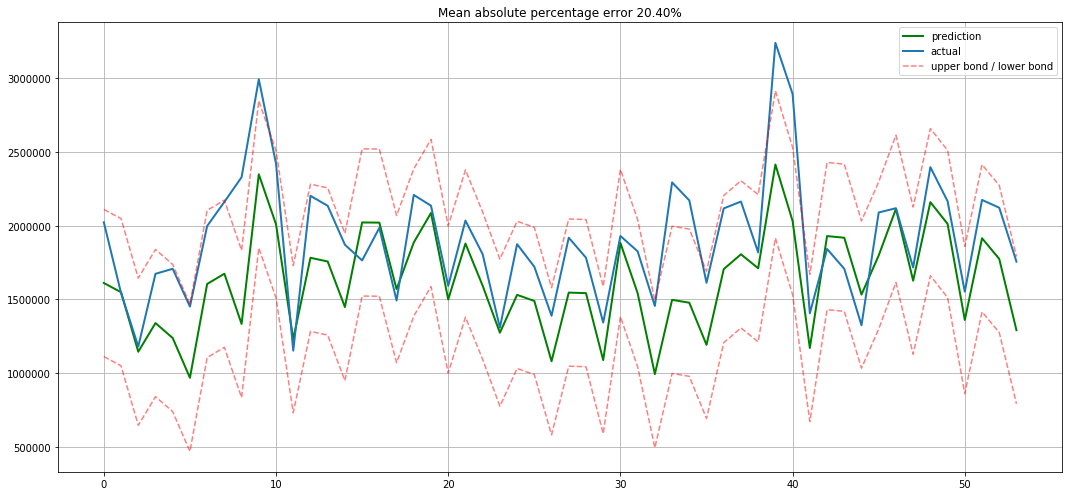

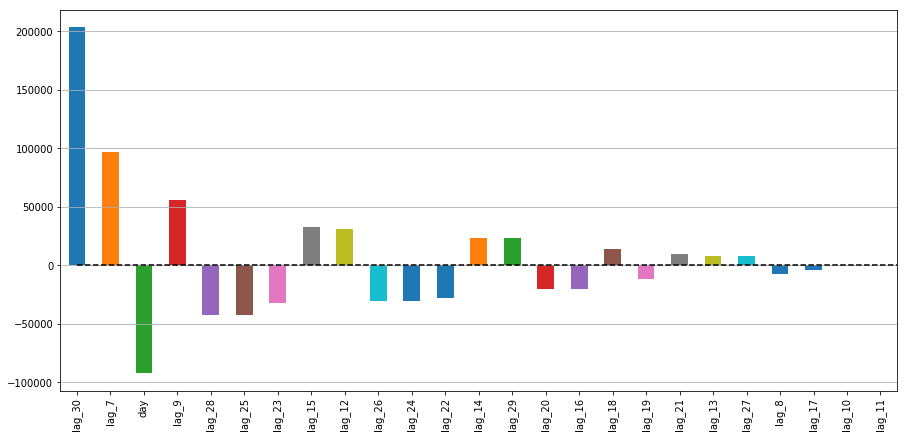

In [86]:
# Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(ridge)

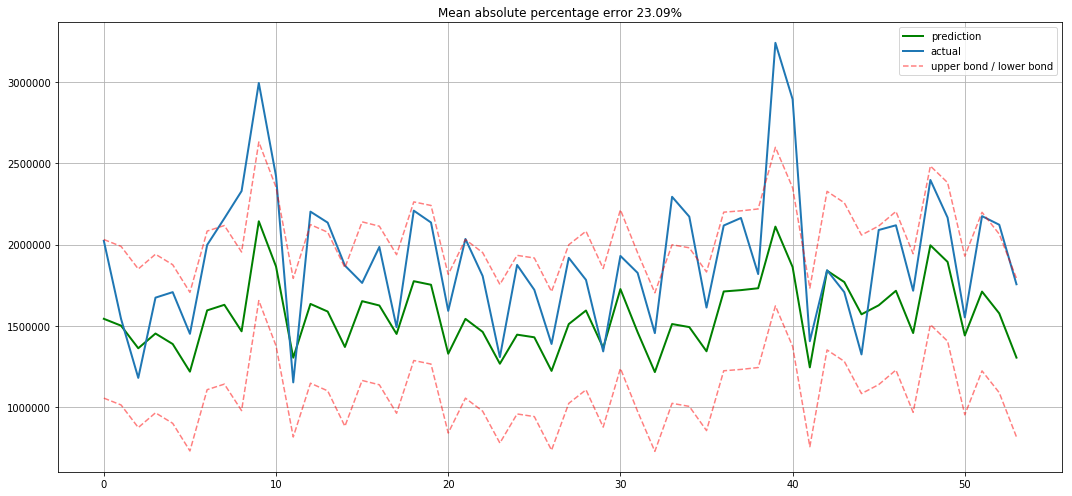

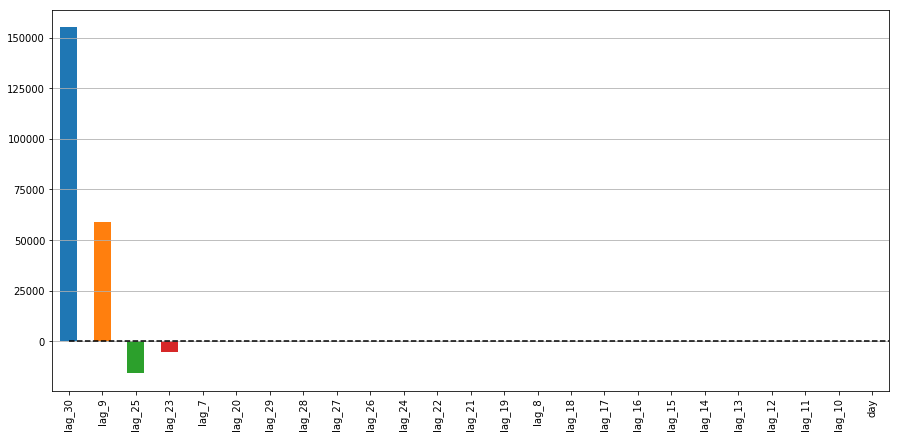

In [87]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(lasso)

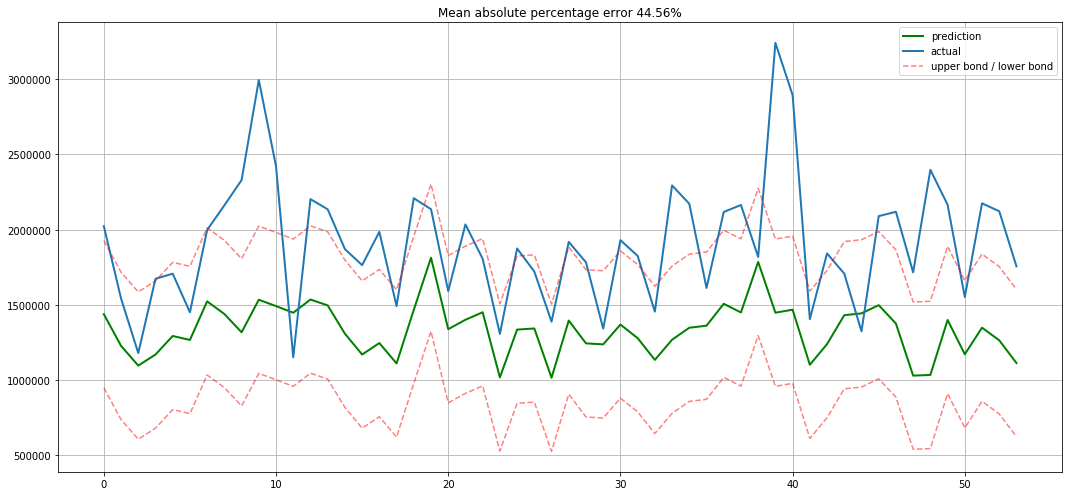

In [90]:
# Забустить этот временной ряд и убедиться, что по умолчанию xgb будет давать отвратительный результат

from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)

# это фиаско, братан!



Крутое бонус-задание

Разбейте подготовленные данные на train и test
Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до len(train). Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть здесь)
Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от len(train) до len(test), очистите тестовый датасет от тренда при помощи этого прогноза
Далее на очищенных от тренда данных train постройте xgboost и постройте прогноз на test
Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

(240, 1) (60, 1)


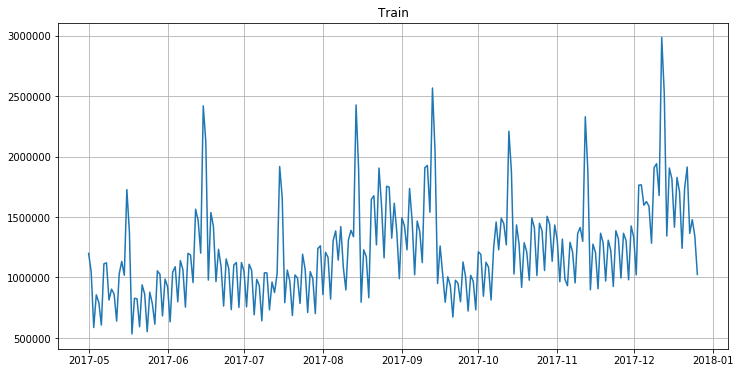

In [49]:
# Разбейте подготовленные данные на train и test

data = pd.DataFrame(currency.GEMS_GEMS_SPENT.copy())
data.columns = ["y"]

train = data[0:int(0.8*len(data))]
test = data[int(0.8*len(data)):len(data)]
y = data.values
print(train.head())
#len(test)

                  y
Time               
2017-05-01  1199436
2017-05-02  1045515
2017-05-03   586111
2017-05-04   856601
2017-05-05   793775


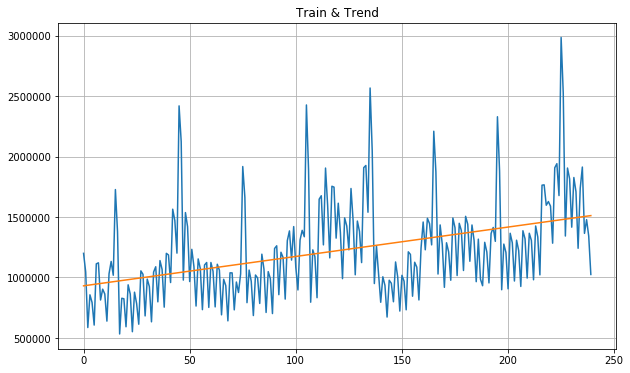

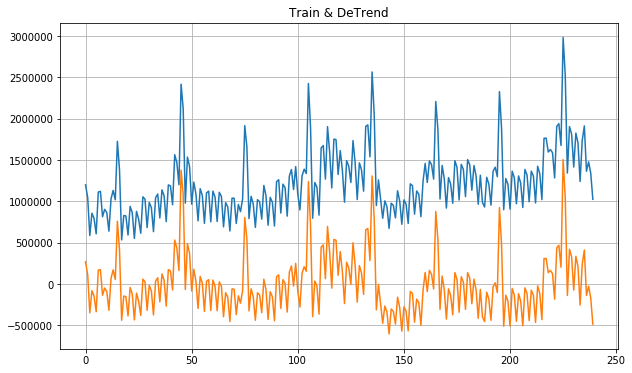

In [50]:
# Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, 
# где таргетом будут значения ряда, а фактором - числовой ряд от 0 до len(train). 
# Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда


# fit linear model
X_train = [i for i in range(0, len(train))]
X_train = np.reshape(X_train, (len(X_train), 1))
y_train = y[0:len(train)]
model = LinearRegression()
model.fit(X_train, y_train)
# calculate trend
trend = model.predict(X_train)
# plot trend
plt.figure(figsize=(10, 6))
plt.plot(y_train)
plt.plot(trend)
plt.title('Train & Trend')
plt.grid(True)
plt.show()

# detrend
detrended_train = [y_train[i]-trend[i] for i in range(0, len(train))]
# plot detrended
plt.figure(figsize=(10, 6))
plt.plot(y_train)
plt.plot(detrended_train)
plt.title('Train & DeTrend')
plt.grid(True)
plt.show()

#clear = []
#for i in range (0, len(train)):
    #clear.append(detrended_train[i])
#print(detrended_train)

In [11]:
#clear[0:5]

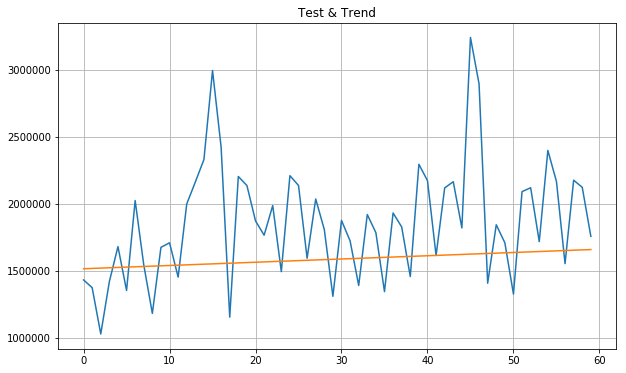

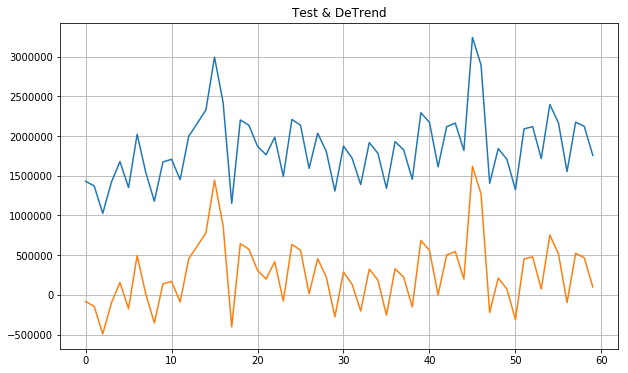

In [51]:
# Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора 
# взять числовой ряд от len(train) до len(test), очистите тестовый датасет от тренда при помощи этого прогноза

X_test = [i for i in range(len(train), len(data))]
X_test = np.reshape(X_test, (len(X_test), 1))
y_test = y[len(train):len(data)] 

predict = model.predict(X_test)

detrended_test = [y_test[i]-predict[i] for i in range(0, len(test))]
# plot trend
plt.figure(figsize=(10, 6))
plt.plot(y_test)
plt.plot(predict)
plt.title('Test & Trend')
plt.grid(True)
plt.show()

# plot detrended
plt.figure(figsize=(10, 6))
plt.plot(y_test)
plt.plot(detrended_test)
plt.title('Test & DeTrend')
plt.grid(True)
plt.show()

<class 'list'>
300


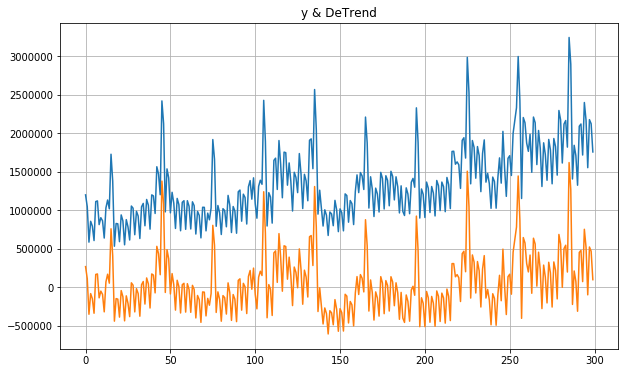

In [52]:
detrended = detrended_train + detrended_test
print(type(detrended))
print(len(detrended))

# plot detrended
plt.figure(figsize=(10, 6))
plt.plot(y)
plt.plot(detrended)
plt.title('y & DeTrend')
plt.grid(True)
plt.show()

In [99]:
# костыльные костыли

df1 = pd.DataFrame(detrended)
df1.columns = ['y2']

mas = df1['y2'].values

data2 = data.copy()

data2['y2'] = mas

data2 = data2.drop(labels='y', axis=1)
data2.columns = ['y']
print (data2.head())

data2.shape

#df_merged = pd.merge(data2, df1, how='inner', on=['y2'])
#data2['value'] = detrended
#data2[['value']] = data2[['value']].apply(pd.to_numeric)
#data2 = pd.merge(data2, df1, on=data2.index, how='outer')
#data2.columns = ['data', 'y', 'value']


#data2.index.names = ['date']
#data2 = data2.assign(value=detrended.values)
#data2.info()
#print (df1.head())

#print(mas)

                        y
Time                     
2017-05-01  268414.023444
2017-05-02  112063.960905
2017-05-03 -349769.101635
2017-05-04  -81708.164174
2017-05-05 -146963.226713


(300, 1)

In [112]:
X_train, X_test, y_train, y_test =\
prepareData(data2, lag_start=0, lag_end=5, test_size=0.2, target_encoding=False) # лаги подбираем так, чтобы в X-test было 60 шт.
# сумма кстати, не равна 300, куда делись остальные элементы мне лично не понятно. Короче танцы с бубнами на костылях.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test.shape, X_train.shape

((60, 6), (236, 6))

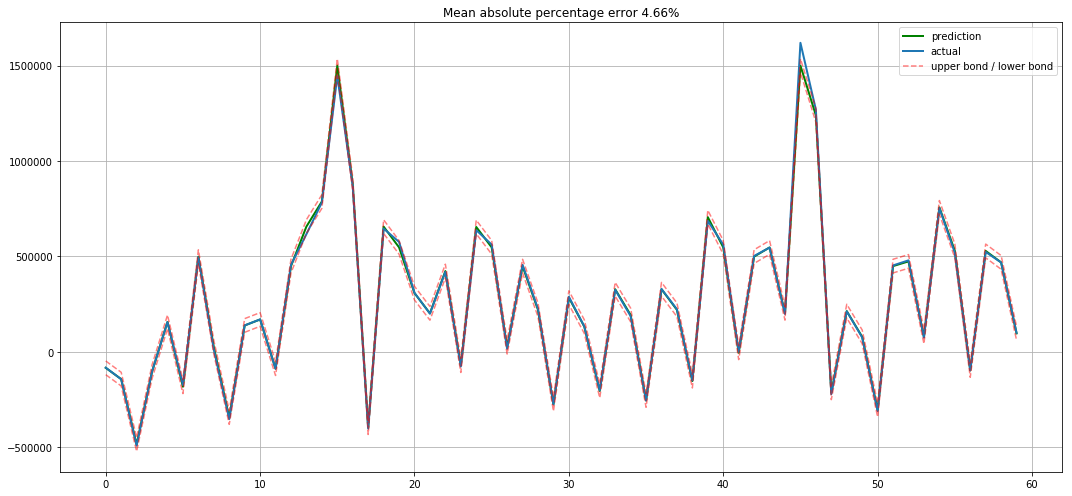

In [113]:
# Далее на очищенных от тренда данных train постройте xgboost и постройте прогноз на test

from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)


In [114]:
# Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый 
# прогноз временного ряда
y_pred = xgb.predict(X_test_scaled) # предсказания бустовой модели на тестовом множестве
predict = predict.flatten() # это тренд на тестовом множестве, полученный гораздо раньше
print(type(y_pred))
print((y_pred))
print()
print(type(predict))
print((predict))

<class 'numpy.ndarray'>
[ -84304.234 -143473.8   -486201.9   -104341.97   156431.34  -183460.5
  498193.03    24135.217 -344746.03   137700.44   169209.81   -88585.805
  448789.4    656157.94   787169.25  1499471.     877100.2   -397708.6
  655746.44   546975.1    307184.16   201264.81   422844.5    -72784.41
  653964.9    546975.1     23961.602  448655.6    219545.14  -275252.
  283541.12   131664.19  -205625.98   327522.66   192800.03  -255211.23
  327522.66   219545.14  -153904.94   705511.6    546975.1     -5456.389
  498610.56   546508.9    201505.02  1499471.    1239191.2   -215275.53
  212979.36    78214.94  -305854.72   448789.4    473456.88    77951.76
  756521.3    529266.6    -97927.336  528388.9    468211.1     96254.48 ]

<class 'numpy.ndarray'>
[1513996.98598326 1516426.04852254 1518855.11106182 1521284.1736011
 1523713.23614038 1526142.29867966 1528571.36121894 1531000.42375823
 1533429.48629751 1535858.54883679 1538287.61137607 1540716.67391535
 1543145.73645463 1545574

In [115]:
res = y_pred + predict
res

array([1429692.75160826, 1372952.25164754, 1032653.20481182,
       1416942.2048511 , 1680144.57989038, 1342681.79867966,
       2026764.39246894, 1555135.6405551 , 1188683.45504751,
       1673558.98633679, 1707497.42387607, 1452130.86922785,
       1991935.14270463, 2201732.73649391, 2335173.11153319,
       3049903.92407247, 2429962.17411175, 1157582.45540103,
       2213466.54919031, 2107124.29922959, 1869762.39301887,
       1766272.11180815, 1990280.86184743, 1497081.01813671,
       2226259.36192599, 2121698.67446527, 1601114.21356705,
       2028237.26829383, 1801555.87770811, 1309187.79962239,
       1870409.98716167, 1720962.11220095, 1386101.00286523,
       1921678.70602951, 1789385.14356879, 1343802.94048307,
       1928965.89364735, 1823417.44056163, 1452396.42497591,
       2314242.05001519, 2158134.61255447, 1608132.1609336 ,
       2114628.17513303, 2164955.55017231, 1822380.75333659,
       3122775.80025087, 2864925.11279015, 1412887.39407943,
       1843571.34724371,

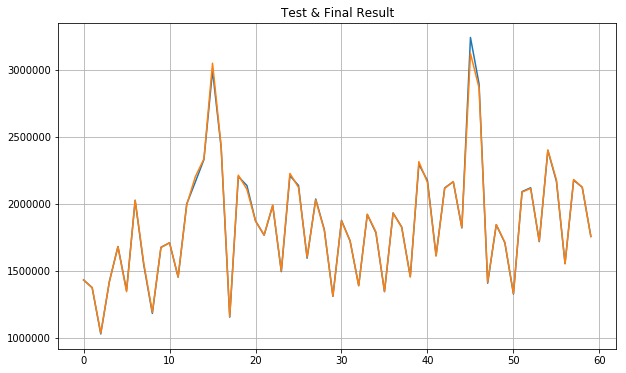

In [116]:
y = data.values
y_test = y[len(train):len(data)]

plt.figure(figsize=(10, 6))
plt.plot(y_test)
plt.plot(res)
plt.title('Test & Final Result')
plt.grid(True)
plt.show()

# вот он наш красивый итоговый прогноз